# Generate marginalise H_0 plot

This section plots the combined estimate H_0 plot
This is related to Figure 8 in the paper

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from anesthetic import read_chains
from anesthetic.samples import merge_samples_weighted
from anesthetic.utils import iso_probability_contours
from scipy.stats import gaussian_kde
from itertools import groupby
from operator import itemgetter

[all] H0 = 70.22 ± 1.93 km s^-1 Mpc^-1  (68% credible)


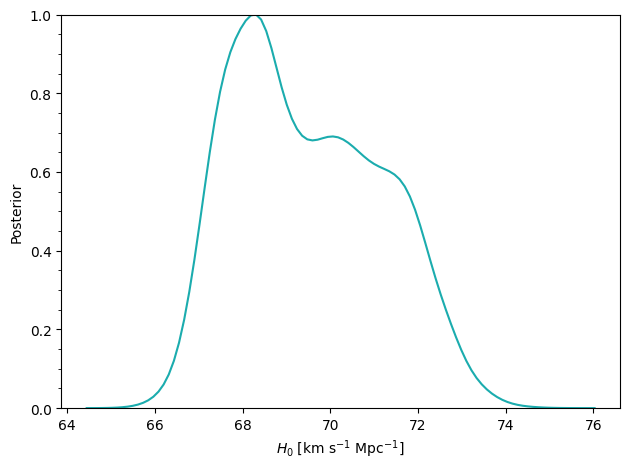

In [ ]:
# Define chain groups with labels and paths to PolyChord outputs
# Each group can include multiple hypotheses for comparison
chain_groups = {
    'all': [
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/LDL Confident/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/CMB/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/CMB Confident/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/LDL/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/Both Biased/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/Faster Early/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/Faster Everywhere/chains/gaussian",
    ]
}

# Define color palette for plotting
colors = ['#1bacae']

# Loop through chain groups and generate 1D posterior plots for H0
for i, (label, paths) in enumerate(chain_groups.items()):
    # Load chains from file paths
    chains = [read_chains(path) for path in paths]

    # Merge samples across chains if needed
    samples = merge_samples_weighted(chains)

    # Plot 1D marginal posterior for parameter p0 (H0)
    samples.plot_1d(['p0'], label=label, color=colors[i % len(colors)])

    # Customize plot labels and style
    plt.ylabel('Posterior')
    plt.xlabel(r'$H_0\; [\mathrm{km}\ \mathrm{s}^{-1}\ \mathrm{Mpc}^{-1}]$')
    plt.ylim(0, 1)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.gca().tick_params(axis='x', which='minor', bottom=False)
    plt.minorticks_on()

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("marginalised_H0.pdf", bbox_inches="tight", dpi=300)
plt.show()


# Credible Intervals

This is just how to calculate the CL's if you need to

In [ ]:
# Define chain groups with labels and corresponding PolyChord output paths
chain_groups = {
    'all': [
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/LDL Confident/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/CMB/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/CMB Confident/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/LDL/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/Both Biased/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/Faster Early/chains/gaussian",
        "/home/quantom97/PolyChordLite/my_tests/new_H0/initial_test/Faster Everywhere/chains/gaussian",
    ]
}


def _interval_from_mask(xgrid, pdf_norm, mask):
    """
    Compute the lowest and highest values of a contiguous interval 
    corresponding to the provided boolean mask. The interval chosen 
    is the one containing the largest probability mass.

    Parameters
    ----------
    xgrid : array-like
        Grid of parameter values.
    pdf_norm : array-like
        Normalized probability density function evaluated on xgrid.
    mask : array-like (bool)
        Boolean mask indicating region above threshold.

    Returns
    -------
    lo, hi : float
        Lower and upper bounds of the interval.
    """
    idx = np.where(mask)[0]
    if idx.size == 0:
        return np.nan, np.nan

    best = (None, None, -np.inf)
    # Iterate over contiguous regions in mask
    for _, grp in groupby(enumerate(idx), key=lambda t: t[0] - t[1]):
        g = list(map(itemgetter(1), grp))
        s, e = g[0], g[-1] + 1
        # Compute probability mass within this segment
        mass = np.trapz(pdf_norm[s:e], xgrid[s:e])
        if mass > best[2]:
            best = (s, e, mass)

    s, e, _ = best
    return xgrid[s], xgrid[e - 1]


def _print_interval(label, p, lo, hi):
    """
    Print formatted credible interval for a given probability level.

    Parameters
    ----------
    label : str
        Label for the chain group.
    p : float
        Probability level (e.g. 0.68 or 0.95).
    lo, hi : float
        Lower and upper bounds of the interval.
    """
    c = 0.5 * (lo + hi)  # central value
    h = 0.5 * (hi - lo)  # half-width
    print(f"[{label}] {int(p*100)}% max-prob interval: {c:.2f} ± {h:.2f}  ({lo:.2f}–{hi:.2f})")


# Loop through each chain group and compute intervals
for label, paths in chain_groups.items():
    # Read and merge chains (weights=None => use evidences)
    chains = [read_chains(path) for path in paths]
    merged_samples = merge_samples_weighted(chains, weights=None, label=label)

    # Extract parameter samples (H0 stored in 'p0') and weights
    x = merged_samples['p0'].values
    w = merged_samples.get_weights()

    # Perform weighted kernel density estimation (KDE)
    xgrid = np.linspace(x.min(), x.max(), 1000)
    kde = gaussian_kde(x, weights=w)
    pdf = kde(xgrid)
    pdf = pdf / np.trapz(pdf, xgrid)  # normalise to unit integral

    # Compute and print 68% credible interval
    level_68 = iso_probability_contours(pdf, contours=[0.68])[0]
    mask_68 = pdf >= level_68
    lo68, hi68 = _interval_from_mask(xgrid, pdf, mask_68)
    _print_interval(label, 0.68, lo68, hi68)

    # Compute and print 95% credible interval
    level_95 = iso_probability_contours(pdf, contours=[0.95])[0]
    mask_95 = pdf >= level_95
    lo95, hi95 = _interval_from_mask(xgrid, pdf, mask_95)
    _print_interval(label, 0.95, lo95, hi95)


[all] 68% max-prob interval: 69.04 ± 1.81  (67.23–70.85)
[all] 95% max-prob interval: 69.69 ± 3.00  (66.69–72.69)
